
## 비정제데이터 체험하기_ds2
# 6. Feature Engineering - 신용거래 이상탐지 데이터 다루기 [프로젝트]
<br/>
<br/>

* 목표
    * 신용거래 사기 여부 예측
        * is_fraud가 사기거래 여부를 나타내는 변수

<br/>

* 할 일
  1. 사기거래 여부를 예측하는 데 불필요한 컬럼을 제거
  2. 최소 2개 이상의 새로운 피처(변수)를 생성
      * [힌트] 구매 금액, 시간 등의 변수를 이용할 수 있음

<br/>

* 여유가 되면 할 일
  1. 데이터의 위도/경도 정보를 활용해보기
  2. 통계적 관점으로 접근하여 유용한 변수를 만들어보기

<br/>

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from geopy.distance import distance

%matplotlib inline

In [27]:
cc_df = pd.read_csv('fraud.csv')

In [28]:
pd.set_option('display.max_columns', 50)

<br/>

# 데이터 살펴보기

* trans_date_trans_time: 거래 날짜 및 시간
    * unix_time 컬럼과 중복이어서 unix_time 삭제
    * 날짜/시간별 패턴이 있을까 하여 trans_date_trans_time를 연, 월, 일, 요일, 시간으로 컬럼을 나눌 계획
* cc_num: 카드 번호
    * 사기 연관성을 특정하기에는 무리가 있어 삭제
* merchant: 상인 이름
    * 사기 연관성을 특정하기에는 무리가 있어 삭제
* category: 거래 종류
* amt: 거래 금액
* first: 고객 이름
    * 사기 연관성을 특정하기에는 무리가 있어 삭제
* last: 고객 성
    * 사기 연관성을 특정하기에는 무리가 있어 삭제
* gender: 고객 성별
* street: 고객 거주지 - 거리
    * 너무 디테일하므로 삭제. 다른 위치 관련 컬럼과도 중복
* city: 고객 거주지 - 도시
    * 너무 디테일하므로 삭제. 다른 위치 관련 컬럼과도 중복
* state: 고객 거주지 - 주
* zip: 고객 거주지 - 우편번호
    * 너무 디테일하므로 삭제. 다른 위치 관련 컬럼과도 중복
* lat: 고객 거주지 - 위도
* long: 고객 거주지 - 경도
* city_pop: 고객 거주 도시 인구 수
    * 사기 연관성을 특정하기에는 무리가 있어 삭제
* job: 고객 직업
* dob: 고객 생년월일
    * 태어난 연도만 남기고, 월, 일은 사기 예측에는 도움 안 될 것 같아 삭제
* trans_num: 거래 번호
    * 사기 연관성을 특정하기에는 무리가 있어 삭제
* unix_time: 거래 날짜 및 시간
    * trans_date_trans_time과 중복이므로 삭제
* merch_lat: 상점 위치 - 위도
* merch_long: 상점 위치 - 경도
* is_fraud: 사기 여부

<br/>

In [29]:
# 데이터 모습 확인

def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    return summary

resumetable(cc_df)

데이터셋 형상: (491134, 22)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,trans_date_trans_time,object,0,488474,2019-01-01 00:00:44,2019-01-01 00:12:34,2019-01-01 00:17:16
1,cc_num,int64,0,124,630423337322,4956828990005111019,180048185037117
2,merchant,object,0,693,"fraud_Heller, Gutmann and Zieme","fraud_Schultz, Simonis and Little",fraud_Kling-Grant
3,category,object,0,14,grocery_pos,grocery_pos,grocery_net
4,amt,float64,0,36446,107.23,44.71,46.28
5,first,object,0,92,Stephanie,Kenneth,Mary
6,last,object,0,102,Gill,Robinson,Wall
7,gender,object,0,2,F,M,F
8,street,object,0,124,43039 Riley Greens Suite 393,269 Sanchez Rapids,2481 Mills Lock
9,city,object,0,121,Orient,Elizabeth,Plainfield


<br/>

# trans_date_trans_time 컬럼을 작은 단위로 나누기

* 날짜/시간별 패턴이 있을까 하여 연, 월, 일, 요일, 시간으로 컬럼을 나눔 (분, 초는 패턴을 보기에는 적합하지 않은 것 같아 제외)

<br/>

In [30]:
# 연도, 월, 일, 요일, 시, 분, 초 컬럼 생성

# datetime 타입으로 변경 
cc_df['trans_datetime'] = pd.to_datetime(cc_df['trans_date_trans_time'])

# 날짜 컬럼 생성 (연, 월, 일)
cc_df['trans_year'] = cc_df['trans_datetime'].dt.year
cc_df['trans_month'] = cc_df['trans_datetime'].dt.month
cc_df['trans_day'] = cc_df['trans_datetime'].dt.day
cc_df['trans_weekday'] = cc_df['trans_datetime'].dt.weekday

# 시간 컬럼 생성 (시간 컬럼만 생성. 분/초는 너무 디테일하여 제외)
cc_df['trans_hour'] = cc_df['trans_datetime'].dt.hour

In [31]:
# 시간 관련 중복 컬럼 삭제
#   1) trans_date_trans_time
#   2) trans_datetime
#   3) unix_time

cc_df = cc_df.drop(['trans_date_trans_time', 'trans_datetime', 'unix_time'], axis=1)

<br/>

# 생년월일 중 연도만 남기기

* 탄생 월, 일은 너무 디테일하여 사기를 예측하기 어려움

<br/>

In [32]:
# 탄생연도 컬럼 추가
cc_df['year_of_birth'] = pd.to_datetime(cc_df['dob']).dt.year

# 기존 dob 컬럼 삭제
cc_df = cc_df.drop(['dob'], axis=1)

<br/>

# 고객 거주지와 결제 상점과의 거리 컬럼 추가

* 사기를 칠 때 집에서 떨어진 곳에서 치지 않을까 싶어서 새로운 컬럼 추가
* lat, long, merch_lat, merch_long 컬럼은 더 이상 사용하지 않으므로 삭제

<br/>

In [33]:
# 고객 거주지와 결제 상점과의 거리 컬럼 추가
cc_df['distance'] = cc_df.apply(
    lambda x: distance((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).km, axis=1)

# lat, long, merch_lat, merch_long 컬럼은 더 이상 사용하지 않으므로 삭제
cc_df = cc_df.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1)

<br/>

# 불필요한 컬럼 삭제

## 사기 예측과 관계가 적거나, 너무 디테일하거나, 다른 컬럼과 겹치는 정보

1. cc_num (카드 번호)
2. merchant (상인 성, 이름)
3. first (고객 이름)
4. last (고객 성)
5. city_pop (고객 거주 도시 인구)
6. trans_num (거래 번호)
7. city (고객 거주지 - 도시)
8. street (고객 거주지 - 거리)
9. zip (우편번호)
10. job (직업)

<br/>

In [34]:
# cc_num, merchant, fist, last, city_pop, trans_num, street, zip, job 컬럼 삭제

cc_df = cc_df.drop(['cc_num', 'merchant', 'first', 'last', 'city_pop', 
                    'trans_num', 'city', 'street', 'zip', 'job'], axis=1)

<br/>

# 이상치 살펴보기

<br/>

In [35]:
# 통계 요약값을 통해 이상치 탐색
#   - 위도(lat, merch_lat): 범위 내 (-90 ~ 90)
#   - 경도(long, merch_long): 범위 내 (-180 ~ 180)

cc_df.describe()

,amt,is_fraud,trans_year,trans_month,trans_day,trans_weekday,trans_hour,year_of_birth,distance
count,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000
mean,69.050120,0.002533,2019.502136,7.154286,15.863487,2.980873,14.123087,1984.384231,76.371652
std,160.322867,0.050264,0.499996,3.425474,8.869727,2.209188,6.406759,9.297579,29.143508
min,1.000000,0.000000,2019.000000,1.000000,1.000000,0.000000,0.000000,1970.000000,0.124180
25%,8.960000,0.000000,2019.000000,4.000000,8.000000,1.000000,10.000000,1976.000000,55.604425
50%,42.170000,0.000000,2020.000000,7.000000,16.000000,3.000000,15.000000,1984.000000,78.563223
75%,80.330000,0.000000,2020.000000,10.000000,24.000000,5.000000,19.000000,1992.000000,98.720741
max,25086.940000,1.000000,2020.000000,12.000000,31.000000,6.000000,23.000000,2004.000000,149.610127


<br/>

# 이상치 확인: 거래 금액

* 문제 없어 보여서 아무 처리 안 함

<br/>

In [36]:
# 최댓값 25086.94가 이상치일지 확인 -> 문제 없어 보여 아무 처리 안 함

cc_df['amt'].sort_values().tail(20)

180201     8255.19
56071      8266.86
38830      8524.52
378122     8645.35
187340     8981.87
30016      9931.82
42020     10469.09
61122     10525.07
9831      10776.59
336301    10881.08
472079    11052.59
480766    11586.34
271107    12025.30
341782    12176.55
352828    13149.15
43412     14630.68
198719    15047.03
410031    16837.08
49446     17897.24
93045     25086.94
Name: amt, dtype: float64

<br/>

# 중복 데이터 확인

* 중복 데이터가 존재하지 않아 처리할 필요 없음

<br/>

In [37]:
# 중복 데이터 확인 -> 중복 데이터가 없어 처리할 것 없음

cc_df[cc_df.duplicated()]

,category,amt,gender,state,is_fraud,trans_year,trans_month,trans_day,trans_weekday,trans_hour,year_of_birth,distance


<br/>

# 컬럼 이름 정리

* amt -> amount

<br/>

In [38]:
# 컬럼 이름 amt를 이해하기 쉽게 amount로 변경

cc_df = cc_df.rename(columns = {'amt': 'amount'})

<br/>

# is_fraud와의 상관관계 확인

* 22 ~ 03시의 늦은 시간에 사기 비율이 상대적으로 높게 나타났다.

<br/>

<AxesSubplot:>

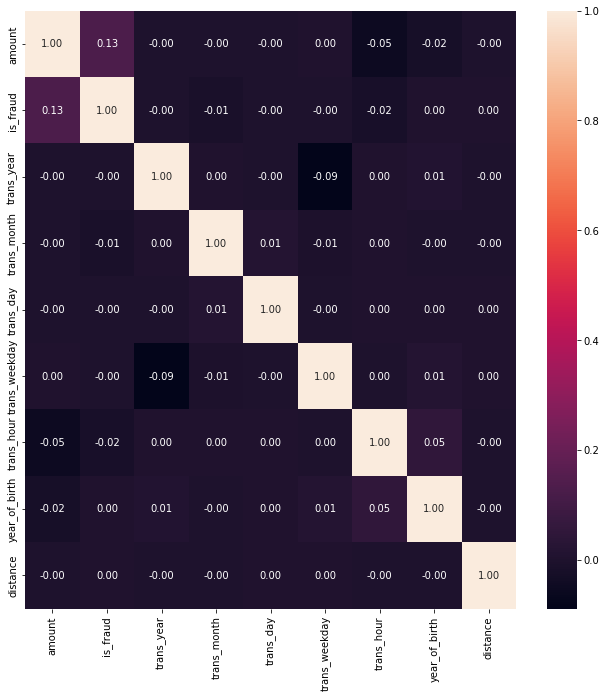

In [39]:
# 상관관계 히트맵 그리기
# 모두 is_fraud와의 상관계수가 낮게 나옴

corrMat = cc_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 11)
sns.heatmap(corrMat, annot=True, fmt='.2f')

In [40]:
# 그래프 그리기 위한 준비 함수

# 그래프에 비율 표시하는 함수 - 도형 객체를 순회하며 막대 상단에 비율 표시
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height() # 도형 높이 (데이터 개수)
        width = patch.get_width() # 도형 너비
        left_coord = patch.get_x() # 도형 왼쪽 테두리의 x축 위치
        percent = height / total_size * 100 # 비율 계산
        
        # 텍스트 입력
        ax.text(x=left_coord + width / 2.0, # x축 위치
                y=height + total_size * 0.001, # y축 위치
                s=f'{percent:1.1f}%', # 입력 텍스트
                ha='center') #가운데 정렬


# 교차분석표 생성 함수
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['is_fraud'], normalize='index') * 100
    crosstab = crosstab.reset_index()
    return crosstab


# 포인트플롯 그리는 함수
def plot_pointplot(ax, feature, crosstab):
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    
    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab,
                        order=crosstab[feature].values, # 프인트플롯 순서
                        color='black', # 포인트플롯 색상
                        legend=False) # 범례 미표시
    
    # y축 범위 설정
    ax2.set_ylim(crosstab[1].min()-0.1, crosstab[1].max()*1.1)
    ax2.set_ylabel('is_fraud ratio(%)')
    

# 주어진 명목형 피처 고윳값별로 is_fraud가 true인 비율을 표시하는 그래프 그리기
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, size=(15, 20)):
    plt.figure(figsize=size) # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.45, hspace=1.5) # 서브플롯 좌우/상하 여백 설정
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature) # 교차분석표 생성
        
        # ax축에 타깃값 분포 카운트플롯 그리기
        sns.countplot(x=feature, data=df,
                      order=crosstab[feature].values,
                      color='skyblue',
                      ax=ax)
        
        write_percent(ax, len(df)) # 비율 표시
        
        plot_pointplot(ax, feature, crosstab) # 포인트플롯 그리기
        
        ax.set_title(f'{feature}') # 그래프 제목 설정

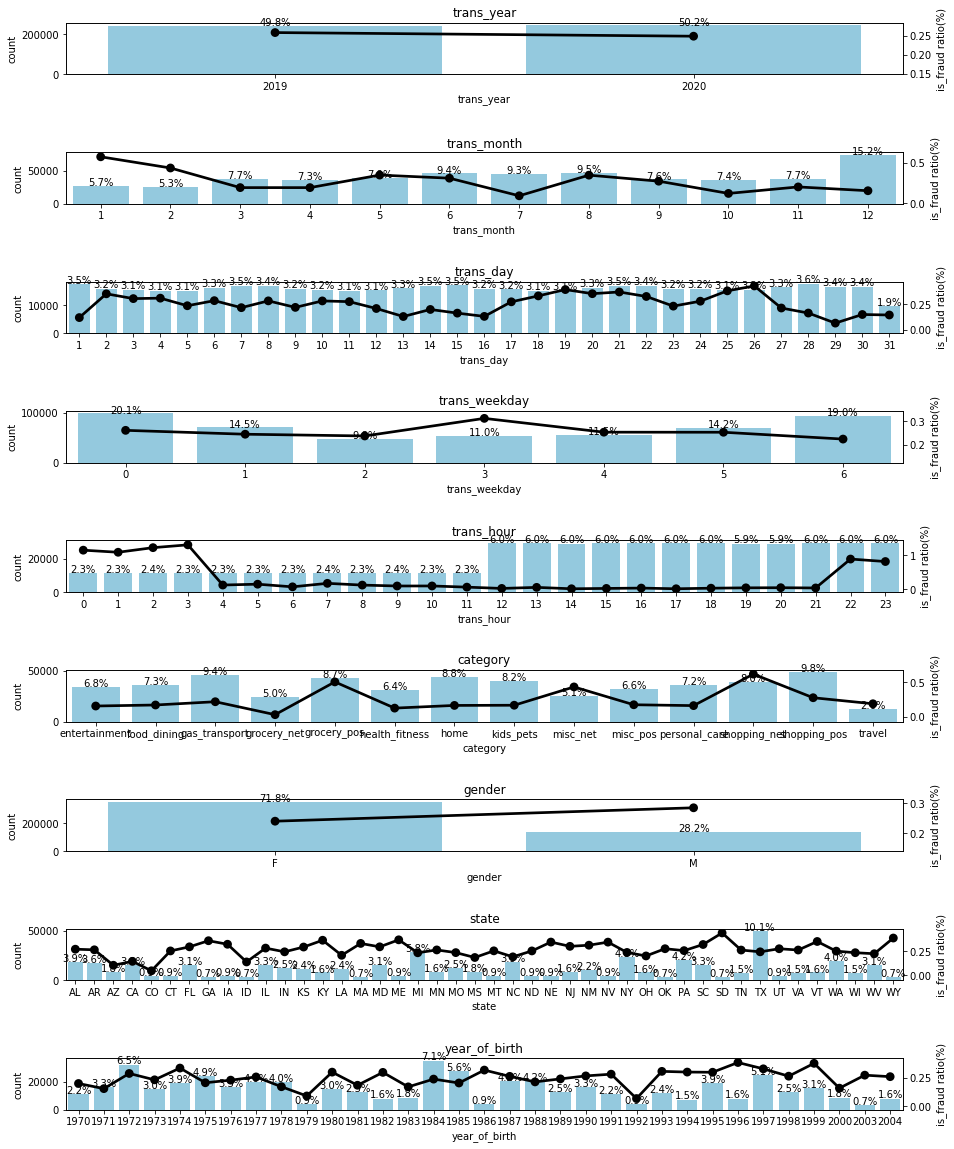

In [41]:
# 명목형 피처와 is_fraud가 1일 때의 관계 그래프로 그리기
#  - trans_hour: 22 ~ 03시의 늦은 시간에 사기 비율이 높음
#  - category: grocery_pos, misc_net, shopping_net에서 상대적으로 사기 비율이 높게 나타남
#  - 나머지는 비슷한 값들이 이어지는 편이어서 그래프로 확연하게 보이는 특징을 찾기는 어려워보임

nom_features = ['trans_year', 'trans_month', 'trans_day', 'trans_weekday', 'trans_hour', 'category', 'gender', 'state', 'year_of_birth']
plot_cat_dist_with_true_ratio(cc_df, nom_features, num_rows=9, num_cols=1)

<br/>

# 범주형 데이터를 숫자로 변환

* gender 값 ('F', 'M') -> (0, 1)로 변경
* 원핫인코딩 적용

<br/>

In [42]:
# 데이터 형태 확인

resumetable(cc_df)

데이터셋 형상: (491134, 12)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,category,object,0,14,grocery_pos,grocery_pos,grocery_net
1,amount,float64,0,36446,107.23,44.71,46.28
2,gender,object,0,2,F,M,F
3,state,object,0,44,WA,NJ,NJ
4,is_fraud,int64,0,2,0,0,0
5,trans_year,int64,0,2,2019,2019,2019
6,trans_month,int64,0,12,1,1,1
7,trans_day,int64,0,31,1,1,1
8,trans_weekday,int64,0,7,1,1,1
9,trans_hour,int64,0,24,0,0,0


In [43]:
# gender 값 변경

cc_df['gender'] = cc_df['gender'].map({'M': 1, 'F': 0})

In [44]:
# 원핫인코딩

oh_df = pd.get_dummies(cc_df, columns=['category', 'state',
                                       'trans_year', 'trans_month',
                                       'trans_day', 'trans_weekday',
                                       'trans_hour', 'year_of_birth'], drop_first=True)

In [45]:
# 컬럼 변화 확인

oh_df.head()

,amount,gender,is_fraud,distance,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AR,state_AZ,state_CA,state_CO,state_CT,state_FL,state_GA,state_IA,...,year_of_birth_1978,year_of_birth_1979,year_of_birth_1980,year_of_birth_1981,year_of_birth_1982,year_of_birth_1983,year_of_birth_1984,year_of_birth_1985,year_of_birth_1986,year_of_birth_1987,year_of_birth_1988,year_of_birth_1989,year_of_birth_1990,year_of_birth_1991,year_of_birth_1992,year_of_birth_1993,year_of_birth_1994,year_of_birth_1995,year_of_birth_1996,year_of_birth_1997,year_of_birth_1998,year_of_birth_1999,year_of_birth_2000,year_of_birth_2003,year_of_birth_2004
0,107.23,0,0,30.216618,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,44.71,1,0,84.714605,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,46.28,0,0,67.768167,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,64.09,1,0,22.322745,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25.58,0,0,79.398244,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<br/>

# 스케일링

<br/>

In [46]:
# 데이터 정보 확인
# 특별한 이상치가 없어 Standard Scaler를 사용하기로 결정

oh_df.describe()

,amount,gender,is_fraud,distance,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AR,state_AZ,state_CA,state_CO,state_CT,state_FL,state_GA,state_IA,...,year_of_birth_1978,year_of_birth_1979,year_of_birth_1980,year_of_birth_1981,year_of_birth_1982,year_of_birth_1983,year_of_birth_1984,year_of_birth_1985,year_of_birth_1986,year_of_birth_1987,year_of_birth_1988,year_of_birth_1989,year_of_birth_1990,year_of_birth_1991,year_of_birth_1992,year_of_birth_1993,year_of_birth_1994,year_of_birth_1995,year_of_birth_1996,year_of_birth_1997,year_of_birth_1998,year_of_birth_1999,year_of_birth_2000,year_of_birth_2003,year_of_birth_2004
count,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,...,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000,491134.000000
mean,69.050120,0.282385,0.002533,76.371652,0.073259,0.093720,0.049856,0.086986,0.063964,0.088245,0.082045,0.051267,0.065992,0.072308,0.079773,0.098435,0.025698,0.035668,0.017814,0.032679,0.008908,0.008922,0.031226,0.007424,0.008908,...,0.040048,0.008912,0.029745,0.025233,0.016342,0.017822,0.071302,0.056465,0.008928,0.041649,0.041620,0.025270,0.032671,0.022291,0.008908,0.023802,0.014845,0.038670,0.016352,0.050548,0.025295,0.031189,0.017818,0.007418,0.016364
std,160.322867,0.450160,0.050264,29.143508,0.260561,0.291439,0.217648,0.281815,0.244689,0.283651,0.274433,0.220542,0.248269,0.258998,0.270941,0.297903,0.158232,0.185462,0.132275,0.177796,0.093961,0.094035,0.173927,0.085840,0.093961,...,0.196072,0.093982,0.169884,0.156834,0.126786,0.132304,0.257329,0.230818,0.094067,0.199785,0.199719,0.156944,0.177775,0.147629,0.093961,0.152432,0.120933,0.192807,0.126825,0.219074,0.157018,0.173829,0.132289,0.085805,0.126872
min,1.000000,0.000000,0.000000,0.124180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.960000,0.000000,0.000000,55.604425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.170000,0.000000,0.000000,78.563223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.330000,1.000000,0.000000,98.720741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [47]:
# StandardScaler 적용

ss = StandardScaler()
ss.fit(oh_df) # 학습. 연산에 필요한 정보(평균, 표준편차 값)를 획득

ss_df = pd.DataFrame(ss.transform(oh_df), columns=oh_df.columns) # 스케일링 연산

In [48]:
# 스케일링 결과 확인

ss_df

,amount,gender,is_fraud,distance,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AR,state_AZ,state_CA,state_CO,state_CT,state_FL,state_GA,state_IA,...,year_of_birth_1978,year_of_birth_1979,year_of_birth_1980,year_of_birth_1981,year_of_birth_1982,year_of_birth_1983,year_of_birth_1984,year_of_birth_1985,year_of_birth_1986,year_of_birth_1987,year_of_birth_1988,year_of_birth_1989,year_of_birth_1990,year_of_birth_1991,year_of_birth_1992,year_of_birth_1993,year_of_birth_1994,year_of_birth_1995,year_of_birth_1996,year_of_birth_1997,year_of_birth_1998,year_of_birth_1999,year_of_birth_2000,year_of_birth_2003,year_of_birth_2004
0,0.238144,-0.627300,-0.050392,-1.583717,-0.281159,-0.321577,-0.229068,3.239760,-0.26141,-0.311104,-0.298961,-0.232459,-0.265810,-0.279185,-0.294428,-0.330428,-0.162405,-0.192322,-0.134674,-0.183803,-0.094805,-0.094882,-0.179533,-0.086482,-0.094805,...,4.895912,-0.094827,-0.175092,-0.160893,-0.128892,-0.134705,-0.277086,-0.244631,-0.094914,-0.208467,-0.208393,-0.161013,-0.183779,-0.150995,-0.094805,-0.156149,-0.122756,-0.200562,-0.128933,-0.230737,-0.161093,-0.179424,-0.134689,-0.086446,-0.128982
1,-0.151820,1.594133,-0.050392,0.286272,-0.281159,-0.321577,-0.229068,3.239760,-0.26141,-0.311104,-0.298961,-0.232459,-0.265810,-0.279185,-0.294428,-0.330428,-0.162405,-0.192322,-0.134674,-0.183803,-0.094805,-0.094882,-0.179533,-0.086482,-0.094805,...,-0.204252,-0.094827,5.711269,-0.160893,-0.128892,-0.134705,-0.277086,-0.244631,-0.094914,-0.208467,-0.208393,-0.161013,-0.183779,-0.150995,-0.094805,-0.156149,-0.122756,-0.200562,-0.128933,-0.230737,-0.161093,-0.179424,-0.134689,-0.086446,-0.128982
2,-0.142027,-0.627300,-0.050392,-0.295211,-0.281159,-0.321577,4.365518,-0.308665,-0.26141,-0.311104,-0.298961,-0.232459,-0.265810,-0.279185,-0.294428,-0.330428,-0.162405,-0.192322,-0.134674,-0.183803,-0.094805,-0.094882,-0.179533,-0.086482,-0.094805,...,-0.204252,-0.094827,-0.175092,-0.160893,-0.128892,-0.134705,-0.277086,-0.244631,-0.094914,-0.208467,-0.208393,-0.161013,-0.183779,-0.150995,-0.094805,-0.156149,-0.122756,-0.200562,-0.128933,-0.230737,-0.161093,-0.179424,-0.134689,-0.086446,-0.128982
3,-0.030938,1.594133,-0.050392,-1.854580,-0.281159,-0.321577,-0.229068,3.239760,-0.26141,-0.311104,-0.298961,-0.232459,-0.265810,-0.279185,-0.294428,-0.330428,-0.162405,-0.192322,-0.134674,-0.183803,-0.094805,-0.094882,-0.179533,-0.086482,-0.094805,...,-0.204252,-0.094827,-0.175092,-0.160893,-0.128892,-0.134705,-0.277086,-0.244631,-0.094914,-0.208467,-0.208393,-0.161013,-0.183779,-0.150995,-0.094805,-0.156149,-0.122756,-0.200562,-0.128933,-0.230737,-0.161093,-0.179424,-0.134689,-0.086446,-0.128982
4,-0.271141,-0.627300,-0.050392,0.103851,-0.281159,-0.321577,-0.229068,-0.308665,-0.26141,-0.311104,-0.298961,-0.232459,3.762089,-0.279185,-0.294428,-0.330428,-0.162405,-0.192322,-0.134674,-0.183803,-0.094805,-0.094882,-0.179533,-0.086482,-0.094805,...,-0.204252,-0.094827,-0.175092,-0.160893,-0.128892,-0.134705,-0.277086,-0.244631,-0.094914,-0.208467,-0.208393,-0.161013,-0.183779,-0.150995,-0.094805,-0.156149,-0.122756,-0.200562,-0.128933,-0.230737,-0.161093,-0.179424,-0.134689,-0.086446,-0.128982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491129,0.406741,-0.627300,-0.050392,0.743638,-0.281159,-0.321577,-0.229068,-0.308665,-0.26141,3.214361,-0.298961,-0.232459,-0.265810,-0.279185,-0.294428,-0.330428,-0.162405,-0.192322,-0.134674,-0.183803,-0.094805,-0.094882,-0.179533,-0.086482,-0.094805,...,-0.204252,-0.094827,-0.175092,-0.160893,-0.128892,7.423635,-0.277086,-0.244631,-0.094914,-0.208467,-0.208393,-0.161013,-0.183779,-0.150995,-0.094805,-0.156149,-0.122756,-0.2005

<br/>

# 회고

* 아직 안개에 싸인 곳이 많다. 명확하게 이해하고 판단할 수 있도록 계속 공부해야 할 것 같다.

<br/>